In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Dense,GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

%matplotlib inline
print(tf.keras.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


2.1.6-tf
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Input constants
HEIGHT = 65
WIDTH = 62
CHANNELS = 3
NUM_CLASSES = 60
NUM_TRAIN_IMAGES = 660

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, CHANNELS))

C:\Users\Laurenz\Anaconda3\envs\tfgpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Data Generator constants
TRAIN_DIR = "simple_clock/Datagenerator_simple_clock/Training"
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                    #rotation_range=0,
                                    #horizontal_flip=False,
                                    #vertical_flip=False,
                                    width_shift_range=0.03,
                                    height_shift_range=0.03,
                                    #shear_range=0.0,
                                    #zoom_range=0,
                                    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

Found 660 images belonging to 60 classes.


In [4]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [5]:
# Top Layer constants
FC_LAYERS = [100, 100, 100, 100]
DROPOUT = 0.05

finetune_model = build_finetune_model(base_model, 
                                      dropout=DROPOUT, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=NUM_CLASSES)

finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65, 62, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 71, 68, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 33, 31, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 33, 31, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Found 60 images belonging to 60 classes.
Img1 - real: 0, pred: 330
Img2 - real: 6, pred: 330
Img3 - real: 12, pred: 312


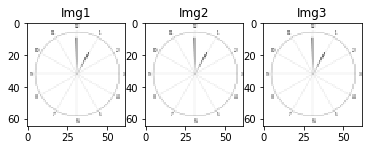

In [7]:
#Testing the model
TEST_DIR = "simple_clock/Datagenerator_simple_clock/Testing"

IMG_PATH_1 = "simple_clock/Datagenerator_simple_clock/Testing/0/clock-01.00.00.PNG"
IMG_PATH_2 = "simple_clock/Datagenerator_simple_clock/Testing/6/clock-04.01.00.PNG"
IMG_PATH_3 = "simple_clock/Datagenerator_simple_clock/Testing/12/clock-07.02.00.PNG"

test_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 target_size=(HEIGHT, WIDTH),
                                                 batch_size=1,
                                                 class_mode=None,  # only data, no labels
                                                 shuffle=False
                                                )  

preds = finetune_model.predict_generator(test_generator, 60)

#visualizing some examples
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img1') 
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img2') 
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img3') 
print("Img1 - real: 0, pred: %d" % (np.argmax(preds[0], axis=0)*6))
print("Img2 - real: 6, pred: %d" % (np.argmax(preds[1], axis=0)*6))
print("Img3 - real: 12, pred: %d" % (np.argmax(preds[2], axis=0)*6))

In [9]:
# Training constants
NUM_EPOCHS = 125
LEARNING_RATE = 0.0001

###optional - loading weights
#finetune_model.load_weights('checkpoints/ResNet50_model_weights.h5')

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor=["acc"],
                             verbose=1,
                             mode='max'
                            )
#early_stopping = EarlyStopping(monitor='acc', min_delta=0.002, patience=4, verbose=0, mode='auto', restore_best_weights=True)

callbacks_list = [checkpoint]

adam = Adam(lr=LEARNING_RATE)

finetune_model.compile(adam,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = finetune_model.fit_generator(train_generator, 
                                       epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE, 
                                       shuffle=True,
                                       #callbacks=callbacks_list
                                      )

Epoch 1/125
82/82 [==============================] - 43s 521ms/step - loss: 4.1178 - acc: 0.0229
Epoch 2/125
82/82 [==============================] - 5s 60ms/step - loss: 4.0867 - acc: 0.0168
Epoch 3/125
82/82 [==============================] - 4s 49ms/step - loss: 4.0549 - acc: 0.0290
Epoch 4/125
82/82 [==============================] - 3s 35ms/step - loss: 4.0003 - acc: 0.0350
Epoch 5/125
82/82 [==============================] - 3s 34ms/step - loss: 3.9497 - acc: 0.0335
Epoch 6/125
82/82 [==============================] - 3s 34ms/step - loss: 3.8531 - acc: 0.0534
Epoch 7/125
82/82 [==============================] - 3s 34ms/step - loss: 3.7508 - acc: 0.0671
Epoch 8/125
82/82 [==============================] - 3s 34ms/step - loss: 3.6365 - acc: 0.0640
Epoch 9/125
82/82 [==============================] - 3s 34ms/step - loss: 3.4959 - acc: 0.0717
Epoch 10/125
82/82 [==============================] - 3s 34ms/step - loss: 3.3398 - acc: 0.0884
Epoch 11/125
82/82 [===========================

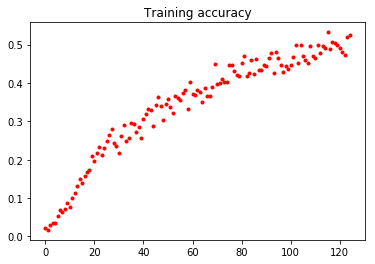

In [11]:
#Plotting constants
PLOT_PATH = 'acc_vs_epochs_resnet50.png'

acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r.')
plt.title('Training accuracy')

plt.savefig(PLOT_PATH)
plt.show()   

Img1 - real: 0, pred: 318
Img2 - real: 6, pred: 318
Img3 - real: 12, pred: 318


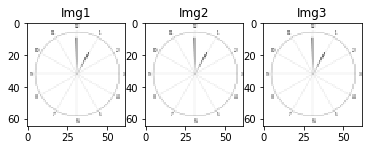

In [12]:
# Testing the model again
preds = finetune_model.predict_generator(test_generator, 60)

#visualizing some examples
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img1') 
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img2') 
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img3') 
print("Img1 - real: 0, pred: %d" % (np.argmax(preds[0], axis=0)*6))
print("Img2 - real: 6, pred: %d" % (np.argmax(preds[1], axis=0)*6))
print("Img3 - real: 12, pred: %d" % (np.argmax(preds[2], axis=0)*6))